In [82]:
import data_mining as dm
from lstm_autoencoder import RecurrentAutoencoder
import train
import numpy as np
import torch
import importlib

In [83]:
importlib.reload(dm)
#importlib.reload(RecurrentAutoencoder)
importlib.reload(train)

<module 'train' from 'c:\\Users\\52333\\Documents\\sisa\\train.py'>

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Limpiamos la data y la dejamos en el formato necesario para entrenar
====================================================================

In [85]:
train_dataset,seq_len,n_features,val_dataset=dm.clean_and_get_Data('benign_sample.csv')

(8385, 2)


el shape del dataset torch.Size([7102, 25, 2, 1])
el shape del dataset torch.Size([5592, 25, 2, 1])
el shape del dataset torch.Size([2743, 25, 2, 1])


In [86]:
print(len(train_dataset))

7127


Creamos el modelo
================

In [87]:
model = RecurrentAutoencoder(seq_len, n_features,128)
#model = model.to(device)

Entrenamos
==========

In [88]:
model, history = train.train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=15
)

Epoch 1: train loss 0.03686336290577519 val loss 0.017233398592257726
Epoch 2: train loss 0.01764027917029704 val loss 0.01688907444009513
Epoch 3: train loss 0.014079776893799972 val loss 0.010500045941579866
Epoch 4: train loss 0.012423545999042936 val loss 0.009158599037335161
Epoch 5: train loss 0.011351917087312076 val loss 0.02080954798712059
Epoch 6: train loss 0.010225442828322336 val loss 0.0043853387771085935
Epoch 7: train loss 0.009279074231898696 val loss 0.0070231394221516585
Epoch 8: train loss 0.008195692488648728 val loss 0.0058089441695503095
Epoch 9: train loss 0.00799112876038613 val loss 0.004992463895212909
Epoch 10: train loss 0.007283855892936033 val loss 0.007185051127664217
Epoch 11: train loss 0.006873695057924545 val loss 0.008060303465752964
Epoch 12: train loss 0.006806236791881417 val loss 0.0039472618432385915
Epoch 13: train loss 0.0063860078656326705 val loss 0.0042287089456366994
Epoch 14: train loss 0.0059811518166976154 val loss 0.004788090675728822

In [89]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

In [90]:
from torch import nn
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [91]:
#import seaborn as sns
from torch import nn
MODEL_PATH = 'model.pth'
loaded_model = torch.load(MODEL_PATH)

# Asegúrate de definir 'device' según corresponda (por ejemplo, 'cpu' o 'cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model = loaded_model.to(device)

# Ahora puedes hacer predicciones con el modelo cargado
# Suponiendo que tienes un conjunto de datos llamado 'mi_dataset'
# que quieres usar para hacer predicciones

_, losses = predict(loaded_model, train_dataset)

#sns.distplot(losses, bins=50, kde=True);

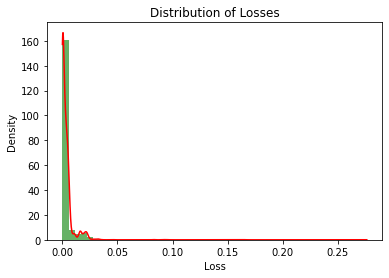

In [92]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Suponiendo que "losses" es una lista de valores de pérdida

# Creamos el histograma
plt.hist(losses, bins=50, density=True, alpha=0.6, color='g')

# Creamos una estimación de densidad de kernel (KDE)
kde = gaussian_kde(losses)
kde_xs = np.linspace(min(losses), max(losses), 1000)
kde_values = kde.evaluate(kde_xs)
plt.plot(kde_xs, kde_values, 'r')

# Añadimos etiquetas y título
plt.xlabel('Loss')
plt.ylabel('Density')
plt.title('Distribution of Losses')

# Mostramos el gráfico
plt.show()


In [93]:
import numpy as np
THRESHOLD = np.mean(losses)
print(THRESHOLD)

0.0035533849629296003


Probemos cómo el modelo se comporta para determinar que una señal de spoofing es anómala
===========================================================================================

In [94]:
anomaly_dataset,Aseq_len,An_features,Aval_dataset=dm.clean_and_get_Data('spoofing_1.csv')

(1685, 2)
el shape del dataset torch.Size([1407, 25, 2, 1])
el shape del dataset torch.Size([1103, 25, 2, 1])
el shape del dataset torch.Size([532, 25, 2, 1])


In [95]:
predictions, pred_losses = predict(loaded_model, anomaly_dataset)
#sns.distplot(pred_losses, bins=50, kde=True);

In [96]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct spoofing anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct spoofing anomaly predictions: 1414/1432


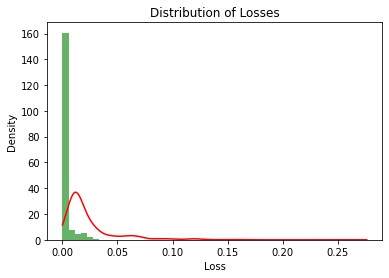

In [97]:
# Creamos el histograma
plt.hist(losses, bins=50, density=True, alpha=0.6, color='g')

# Creamos una estimación de densidad de kernel (KDE)
kde = gaussian_kde(pred_losses)
kde_xs = np.linspace(min(losses), max(losses), 1000)
kde_values = kde.evaluate(kde_xs)
plt.plot(kde_xs, kde_values, 'r')

# Añadimos etiquetas y título
plt.xlabel('Loss')
plt.ylabel('Density')
plt.title('Distribution of Losses')

# Mostramos el gráfico
plt.show()


Ahora veamos cómo detecta los DDOS
==================================

In [98]:
anomaly_dataset,Aseq_len,An_features,Aval_dataset=dm.clean_and_get_Data('ddos_short_sample.csv')

(40358, 2)
el shape del dataset torch.Size([34279, 25, 2, 1])
el shape del dataset torch.Size([27014, 25, 2, 1])
el shape del dataset torch.Size([13294, 25, 2, 1])


In [99]:
predictions, pred_losses = predict(loaded_model, anomaly_dataset)
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct spoofing anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct spoofing anomaly predictions: 1217/34304


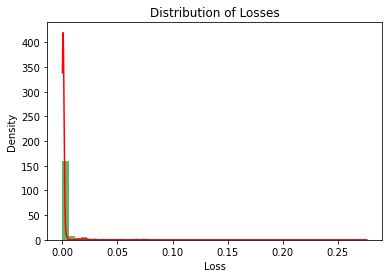

In [100]:
plt.hist(losses, bins=50, density=True, alpha=0.6, color='g')

# Creamos una estimación de densidad de kernel (KDE)
kde = gaussian_kde(pred_losses)
kde_xs = np.linspace(min(losses), max(losses), 1000)
kde_values = kde.evaluate(kde_xs)
plt.plot(kde_xs, kde_values, 'r')

# Añadimos etiquetas y título
plt.xlabel('Loss')
plt.ylabel('Density')
plt.title('Distribution of Losses')

# Mostramos el gráfico
plt.show()

Ahora con ataques de fuerza bruta
=======================================

In [101]:
anomaly_dataset,Aseq_len,An_features,Aval_dataset=dm.clean_and_get_Data('brute_force_sample.csv')

(7208, 2)
el shape del dataset torch.Size([6101, 25, 2, 1])
el shape del dataset torch.Size([4804, 25, 2, 1])
el shape del dataset torch.Size([2354, 25, 2, 1])


In [102]:
predictions, pred_losses = predict(loaded_model, anomaly_dataset)
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct  brute force attack predictions: {correct}/{len(anomaly_dataset)}')

Correct  brute force attack predictions: 3521/6126


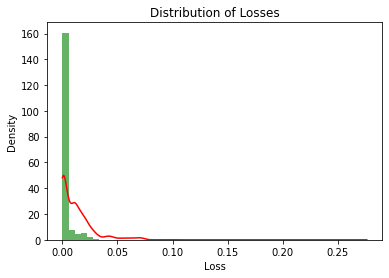

In [103]:
plt.hist(losses, bins=50, density=True, alpha=0.6, color='g')

# Creamos una estimación de densidad de kernel (KDE)
kde = gaussian_kde(pred_losses)
kde_xs = np.linspace(min(losses), max(losses), 1000)
kde_values = kde.evaluate(kde_xs)
plt.plot(kde_xs, kde_values, 'r')

# Añadimos etiquetas y título
plt.xlabel('Loss')
plt.ylabel('Density')
plt.title('Distribution of Losses')

# Mostramos el gráfico
plt.show()